### This code has a custom callback that is a combination of early stopping, reduce learning rate on plateau 
### and model checkpoint. It has the following input parameters
callbacks=[LRA(model=model,patience=patience,stop_patience=stop_patience, threshold=threshold,
            factor=factor,dwell=dwell, model_name=model_name, freeze=freeze, batches=batches,initial_epoch=0 )] 
The callback initially monitor the training accuracy. If the training accuracy fails to improve for 'patience'
number of epochs the learning rate is reduced by to the value new lr= current lr * factor' Once the training
accuracy exceeds the level set by the parameter 'threshold' the callback switches to monitor validation loss.
Again if validation loss fails to decrease for 'patience' number of consecutive epochs the learning rate is
reduced as discribed above. Parameter 'stop_patience' is used to set how many consecutive adjustments of the
learning rate can occur without metric improvement before training is terminated.Parameter model is the model
you created with model.compile in your code. Parameter model_name is a string for the name of your model for
example 'Mobilenet'. Parameter 'dwell' is a boolean. If set to True then if the current epoch resulted in no
improvement of the metric, the models weights are set back to the weights of the model in the previous epoch 
and the learning rate is reduced. Logic here is if the metric did not improve you moved to a location in N space
(N being the number of trainable parameters in the model) that is not as favorable as the position you were in
for the previous epoch. So why stay in this less favorable location, rather go back to the previous location by setting the model weights back to those of the previous epoch. Parameter 'Freeze' is just for display purpose. See the
image below. It simply tells the callback to print 'training all layers' Batches is an interger that is the
value of the number of training steps. For example if your traning set has 10000 samples and you set the batch
size to 100 than set batch= samples/batch_size. In the code below jog down to where the callback prints out
the training data to see how the information is displayed. Not batch count data disappears when training is completed.
you see the running batch count and total number of batches to be processed per epoch. This is a substitute for
the model.fit progress bar. In model.fit I set verbose=0 to stop the model,fit printout and let the callback
print the result for each epoch as shown in the image below.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

### Unused code experiment with masking
imgpath=r'../input/ham1000-segmentation-and-classification/images/ISIC_0024306.jpg'
maskpath=r'../input/ham1000-segmentation-and-classification/masks/ISIC_0024306_segmentation.png'

plt.figure(figsize=(10, 20))
plt.subplot(5, 2,  1)
img=plt.imread(imgpath)
plt.title('input image')
plt.imshow(img/255)
mask=plt.imread(maskpath)
maxpix=np.max(mask)
print ('mask maximum pixel value= ',maxpix)
plt.subplot(5, 2,  2)
plt.title('mask')
plt.imshow(mask)
b, g, r = cv2.split(img)
print ('blue channel max pixel value= ', np.max(b))
plt.subplot(5,2,3)
plt.title('blue channel')
plt.imshow(b)
plt.subplot(5,2,4)
plt.title('bm=blue * mask')
bm=b*mask
print('blue channel masked max pixel value= ', np.max(bm))
plt.imshow(bm)
gm=g*mask
plt.subplot(5, 2,  5)
plt.title('green channel')
plt.imshow(g)
plt.subplot(5, 2,  6)
plt.title('gm=green * mask')
plt.imshow(gm)
rm=g * mask
plt.subplot(5,2,7)
plt.title('red channel')
plt.imshow(r)
plt.subplot(5,2,8)
plt.title('rm=red * mask')
plt.imshow(rm)
masked_img= cv2.merge([bm, gm, rm])/255
print('max pixel value of result= ', np.max(masked_img))
plt.subplot(5,2,9)
plt.title('merged(bm,gm,rm)')
plt.imshow(masked_img)
plt.show()

### input an image and get the shape

(450, 600, 3)


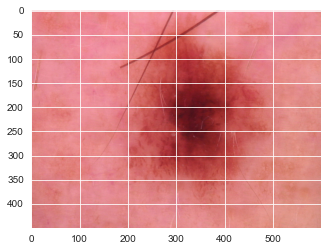

In [2]:
fpath=r'C:\Users\Admin\Desktop\SS1- skin disease\input\images\ISIC_0024306.jpg'
img=plt.imread(fpath)
print (img.shape)
plt.imshow(img)

### read in the csv file

In [3]:
df=pd.read_csv(r'C:\Users\Admin\Desktop\SS1- skin disease\input\GroundTruth.csv')
print (df.head())
print (len(df))
print (df.columns)
labels=['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

          image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0
10015
Index(['image', 'MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'], dtype='object')


## Warning the column image does NOT include the extension '.jpg' so to work need to modify the image column

In [4]:
df['image']=df['image'].apply(lambda x: x+ '.jpg')
print (df.head())

              image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310.jpg  1.0  0.0  0.0    0.0  0.0  0.0   0.0


### one hot encoding caused problem when trying to create ImageDataGenerator.flow_from_dataframe even with  class_mode='raw'
as a work around create a new column in df labels that contains the string version of the label, like "MEL" , "NV" etc
then you can use this as y_col=labels with class_mode='categorical

In [5]:
labels=['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
label_list=[]
for i in range (len(df)):
    row= list(df.iloc[i])
    del row[0]
    index=np.argmax(row)
    label=labels[index]
    label_list.append(label)
df['label']= label_list
df=df.drop(labels, axis=1)
print (df.head())

              image label
0  ISIC_0024306.jpg    NV
1  ISIC_0024307.jpg    NV
2  ISIC_0024308.jpg    NV
3  ISIC_0024309.jpg    NV
4  ISIC_0024310.jpg   MEL


### split df into train, test and valid dataframes

In [6]:
train_split=.95 # set this to the percentof the data you want to use for training
valid_split=.025 # set this to the percent of the data you want to use for validation
# Note percent of data sed for test is 1-train_split-valid_split
dummy_split=valid_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
valid_df, test_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print(' train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))  
print (train_df.head())
print (train_df['label'].value_counts())

 train_df length:  9514   test_df length:  251   valid_df length:  250
                 image label
3231  ISIC_0027537.jpg    NV
7927  ISIC_0032233.jpg    NV
6141  ISIC_0030447.jpg    NV
5967  ISIC_0030273.jpg    NV
7336  ISIC_0031642.jpg   MEL
NV       6384
MEL      1053
BKL      1035
BCC       488
AKIEC     309
VASC      138
DF        107
Name: label, dtype: int64


### dataset is highly out of balance limit maximum samples per class to 300 samples to help balance it

In [8]:
print ('original number of classes: ', len(df['label'].unique()))     
size=300 # set number of samples for each class
samples=[]
group=df.groupby('label')
for label in df['label'].unique():
    Lgroup=group.get_group(label)
    count=int(Lgroup['label'].value_counts())    
    if count>=size:
        sample=Lgroup.sample(size, axis=0)        
    else:        
        sample=Lgroup.sample(frac=1, axis=0)
    samples.append(sample) 
train_df=pd.concat(samples, axis=0).reset_index(drop=True)
print (len(train_df))
print ('final number of classes: ', len(train_df['label'].unique()))       
print (train_df['label'].value_counts())  

original number of classes:  7
1757
final number of classes:  7
NV       300
MEL      300
BKL      300
AKIEC    300
BCC      300
VASC     142
DF       115
Name: label, dtype: int64


### create train, test, valid  generators

In [7]:
sdir=r'C:\Users\Admin\Desktop\SS1- skin disease\input\images' # main directory where data is stored
save_dir=r'./' # output directory where model will be saved
subject='cancer' # part of the name of the saved model
height=224  # image height
width=224   # image width
channels=3  # number of coloor channels
batch_size=40  # model batch size for training and evaluation
img_shape=(height, width, channels)
img_size=(height, width)
# code below determines test generator batch size and steps so that test_batch_size X test_steps = number of test samples
# ensures that for predictions you go through the test set exactly once
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
#
def scalar(img): # unused for efficientnet model
    return img/127.5-1  # scale pixel between -1 and +1
gen=ImageDataGenerator() # no scaling of pixels is need for efficientnet
train_gen=gen.flow_from_dataframe( train_df, sdir, x_col='image', y_col='label', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen=gen.flow_from_dataframe( test_df, sdir, x_col='image', y_col='label', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
valid_gen=gen.flow_from_dataframe( valid_df, sdir, x_col='image', y_col='label', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

classes=list(train_gen.class_indices.keys())

class_count=len(classes)
train_steps=int(len(train_gen.labels)/batch_size)

test batch size:  1   test steps:  251
Found 9514 validated image filenames belonging to 7 classes.
Found 251 validated image filenames belonging to 7 classes.
Found 250 validated image filenames belonging to 7 classes.


### train data is still misblanced but not as bad use class_weight  to help with this

In [8]:
class_weight={}
train_dict=train_gen.class_indices
classes=list(train_dict.keys())
class_count=len(classes)
labels=train_gen.labels
count_array=np.zeros((class_count))
for value in train_dict.values(): # these are the integer values of the labels
    for label in labels: # iterate through the train_gen labels   
        if label==value:
            count_array[value] +=1    
#print (count_array)
max_samples=np.max(count_array)
max_index=np.argmax(count_array)
max_class=classes[max_index]
print('class ', max_class,' with ', max_samples, 'samples has the largest sample size')
msg='{0:^30s}{1:^10s}{2:^9s}'.format('Class', 'Samples', 'Weight')
print(msg)
for i in range (class_count):
    class_weight[i]= max_samples/count_array[i]
    msg=f'{classes[i]:^30s}{str(count_array[i]):^10s}{class_weight[i]:^9.5f}'
    print (msg)

class  NV  with  6384.0 samples has the largest sample size
            Class              Samples   Weight  
            AKIEC               309.0   20.66019 
             BCC                488.0   13.08197 
             BKL                1035.0   6.16812 
              DF                107.0   59.66355 
             MEL                1053.0   6.06268 
              NV                6384.0   1.00000 
             VASC               138.0   46.26087 


### create function to show some image examples

In [14]:
def show_image_samples(gen ):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]/255 # scale images between 0 and 1 becaue no preprocessing scaling was done for efficientnet
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

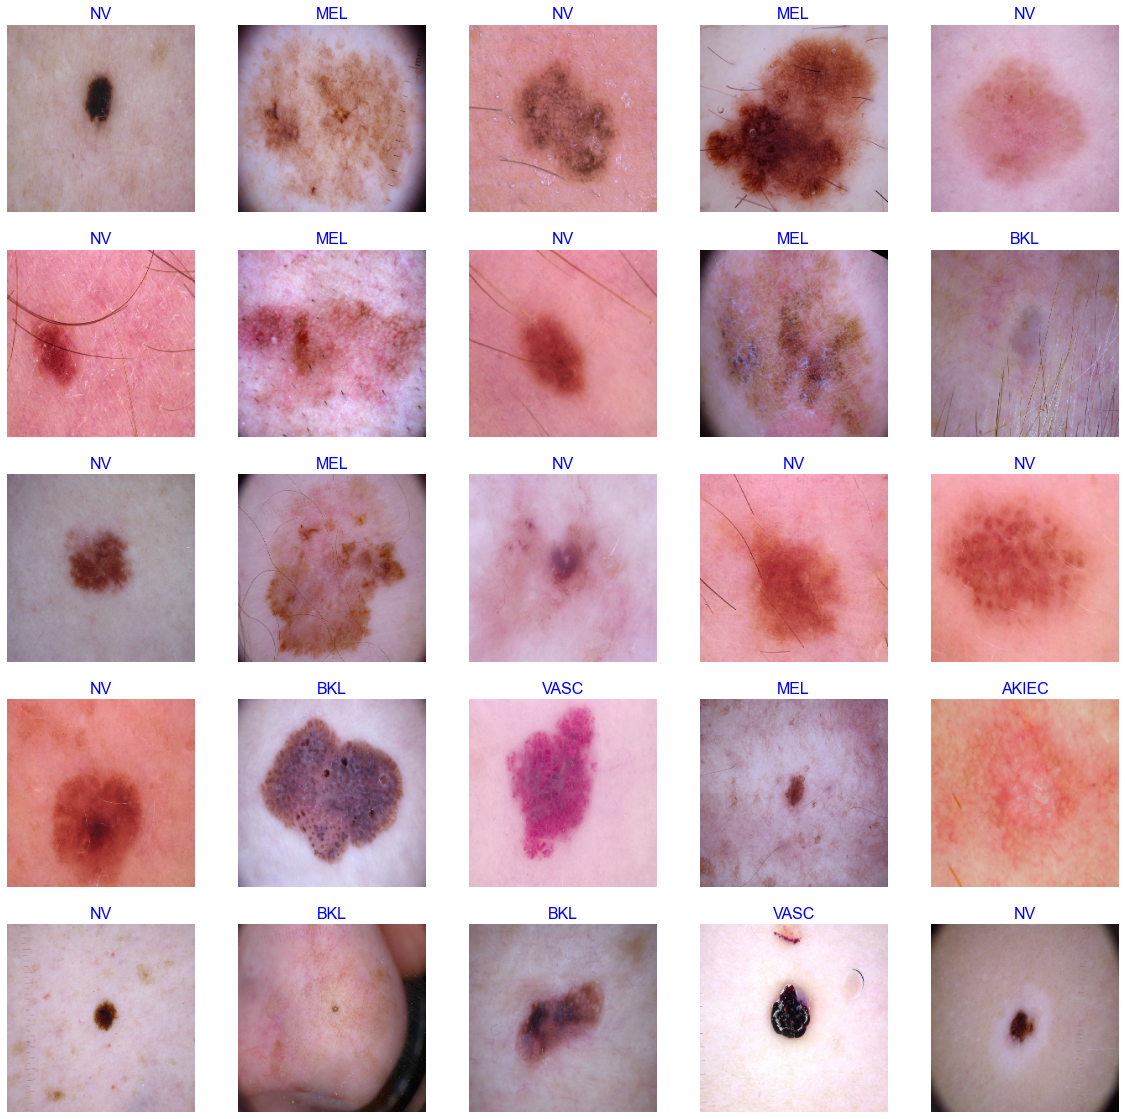

In [15]:
show_image_samples(train_gen)

### define function to print text in RGB foreground and background colors

In [16]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

### create the model

In [17]:
model_name='EfficientNetB5'
base_model=tf.keras.applications.EfficientNetB1(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(lr=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

### create a subclass of callbacks to control learning rate and print training results for each epoch

In [18]:
class LRA(keras.callbacks.Callback):
    reset=False
    count=0
    stop_count=0
    tepochs=0
    def __init__(self,model, patience,stop_patience, threshold, factor, dwell, model_name, freeze,batches, initial_epoch):
        super(LRA, self).__init__()
        self.model=model
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience=stop_patience
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.dwell=dwell
        self.lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it in self.lr
        self.highest_tracc=0.0 # set highest training accuracy to 0
        self.lowest_vloss=np.inf # set lowest validation loss to infinity
        #self.count=0 # initialize counter that counts epochs with no improvement
        #self.stop_count=0 # initialize counter that counts how manytimes lr has been adjustd with no improvement  
        self.initial_epoch=initial_epoch 
        self.batches=batches
        #self.epochs=epochs
        best_weights=self.model.get_weights() # set a class vaiable so weights can be loaded after training is completed        
        msg=' '
        if freeze==True:
            msgs=f' Starting training using  base model { model_name} with weights frozen to imagenet weights initializing LRA callback'
        else:
            msgs=f' Starting training using base model { model_name} training all layers '            
        print_in_color (msgs, (244, 252, 3), (55,65,80)) 
    def on_train_begin(self, logs=None):
        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration', 'Batch')
        print_in_color(msg, (244,252,3), (55,65,80)) 
        
    def on_train_batch_begin(self, batch, logs=None):
        msg='{0:83s}{1:4s}of {2:5s}'.format(' ', str(batch), str(self.batches))
        print(msg, '\r', end='') # prints over on the same line to show running batch count
        
        
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        later=time.time()
        duration=later-self.now 
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr=lr
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy 
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')
        #print ( '\n',v_loss, self.lowest_vloss, acc, self.highest_tracc)
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor='accuracy'
            if acc>self.highest_tracc: # training accuracy improved in the epoch                
                self.highest_tracc=acc # set new highest training accuracy
                LRA.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.lr=lr
            else: 
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience -1:
                    color=(245, 170, 66)
                    self.lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space                        
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss                                    
                else:
                    self.count=self.count +1 # increment patience counter                    
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor='val_loss'
            if v_loss< self.lowest_vloss: # check if the validation loss improved 
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss                
                LRA.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved  
                self.stop_count=0  
                color=(0,255,0)
                self.lr=lr
            else: # validation loss did not improve
                if self.count>=self.patience-1:
                    color=(245, 170, 66)
                    self.lr=self.lr * self.factor # adjust the learning rate                    
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted 
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space
                else: 
                    self.count =self.count +1 # increment the patience counter                    
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(LRA.tepochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{self.lr:^9.5f}{monitor:^11s}{duration:^8.2f}'
        print_in_color (msg,color, (55,65,80))
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(msg, (0,255,0), (55,65,80))
            self.model.stop_training = True # stop training

### Instantiate the callback and train the model

In [ ]:
epochs =10
patience= 1 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =3 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
batches=train_steps
callbacks=[LRA(model=model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, model_name=model_name, freeze=freeze, batches=batches,initial_epoch=0 )]
LRA.tepochs=epochs  # used to determine value of last epoch for printing
history=model.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0, class_weight=class_weight)

 Starting training using base model EfficientNetB5 training all layers 

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  Duration Batch  



### define function to plot the training data

In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()


### define function to generate the confusion matrix and classification report

In [ ]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

### evaluate model on the test set then save the model

In [ ]:
tr_plot(history,0)
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)

### make predictions on test set and generate confusion matrix and classification report

In [ ]:
print_code=0
preds=model.predict(test_gen) 
print_info( test_gen, preds, print_code, save_dir, subject )  